#### Code to train models

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
cd ../src

/home/theo/kaggle/siim_covid/src


## Imports

In [4]:
import os
import cv2
import ast
import json
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm

In [5]:
from params import *

In [7]:
from data.preparation import prepare_dataframe, handle_duplicates, add_additional_boxes
from data.dataset import CovidDetDataset, CovidClsDataset
from data.transforms import get_transfos_det, get_transfos_cls

from model_zoo.models import get_model
from model_zoo.encoders import get_encoder

from utils.plot import plot_sample
from utils.boxes import treat_boxes
from utils.logger import prepare_log_folder, save_config, create_logger, update_overall_logs

from training.main import k_fold

## Data

### Load

In [8]:
df = prepare_dataframe().copy()

In [9]:
clusts = np.load("../output/clusts.npy", allow_pickle=True)
found = np.load("../output/found.npy")
transpositions = np.load("../output/transpositions.npy", allow_pickle=True)

df = handle_duplicates(df, clusts, transpositions, plot=False)

In [10]:
df = add_additional_boxes(df)

In [11]:
boxes = pd.read_csv('../output/lungs_train')
df = df.merge(boxes, left_on="image_id", right_on="img_name", suffixes=('', '_lung'))
df['boxes_lung'] = df['boxes_lung'].apply(lambda x: np.array(ast.literal_eval(x)))

In [ ]:
boxes = json.load(open('../output/boxes_dic.json', 'r'))
boxes = pd.DataFrame.from_dict(boxes).T.reset_index().rename(columns={"index": "image_id", 0: "boxes_lung"})

df = df.merge(boxes, on="image_id")

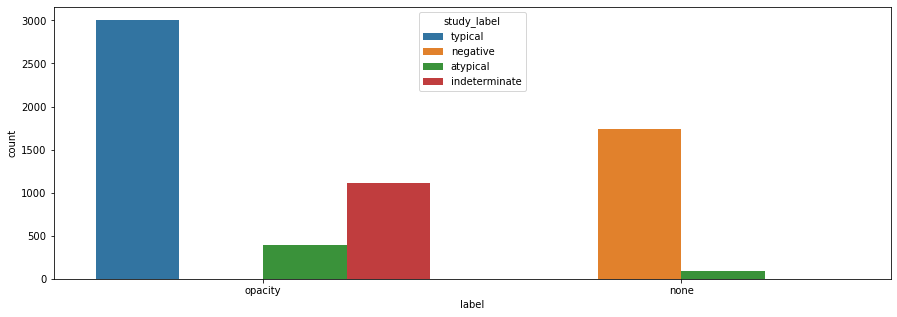

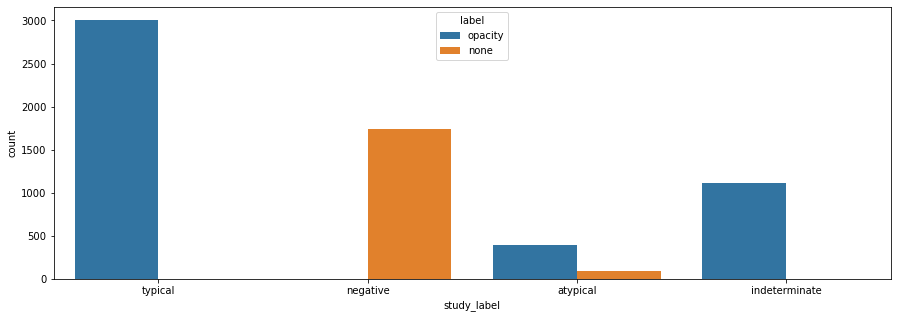

In [12]:
plt.figure(figsize=(15, 5))
sns.countplot(x="label", hue="study_label", data=df)
plt.show()

plt.figure(figsize=(15, 5))
sns.countplot(x="study_label", hue="label", data=df)
plt.show()

### Dataset

In [42]:
# df_ = df[df['crop_starts'].apply(lambda x: np.max(x) > 100)].reset_index()
df_ = df

In [43]:
# transforms = get_transfos_det(augment=False, bbox_format="yolo")
transforms = get_transfos_cls(augment=False)

In [44]:
# dataset = CovidDetDataset(df_, DATA_PATH + f"train_{SIZE}/", bbox_format="yolo", transforms=transforms)
dataset = CovidClsDataset(df_, DATA_PATH + f"train_{SIZE}/", transforms=transforms)

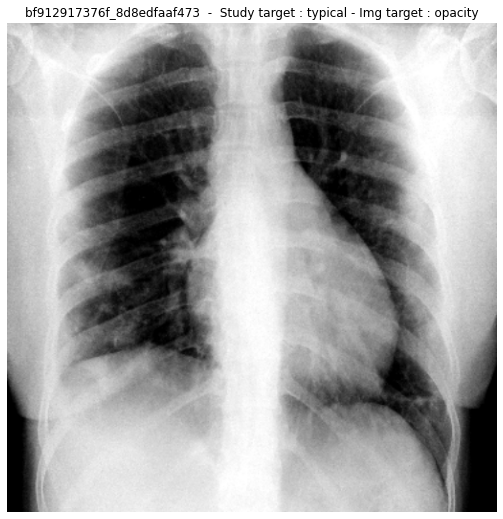

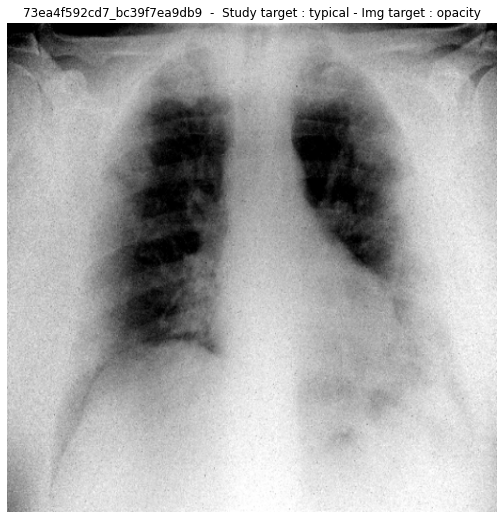

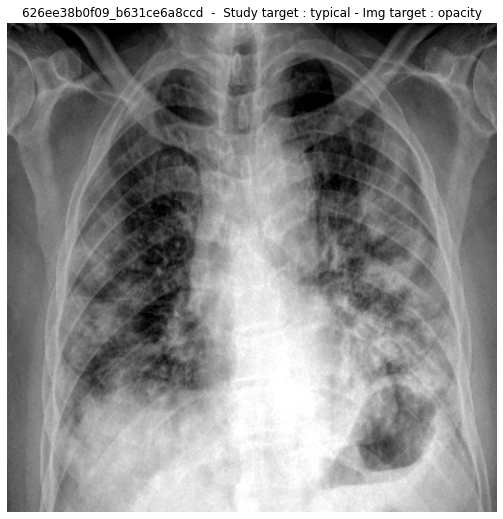

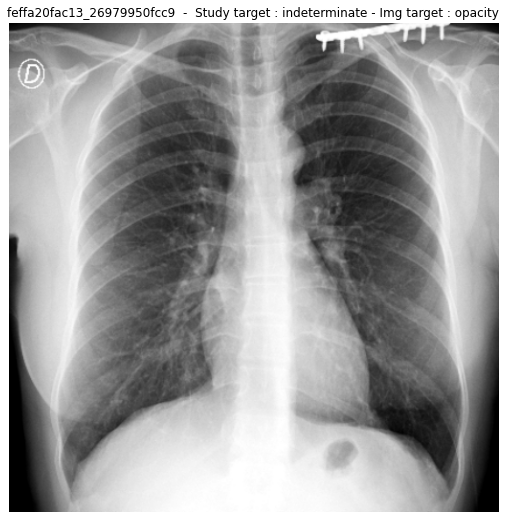

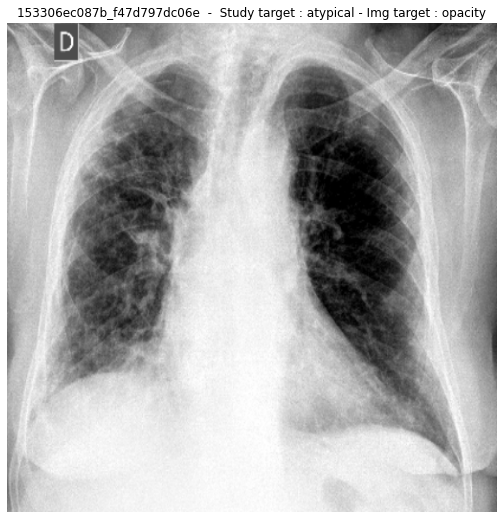

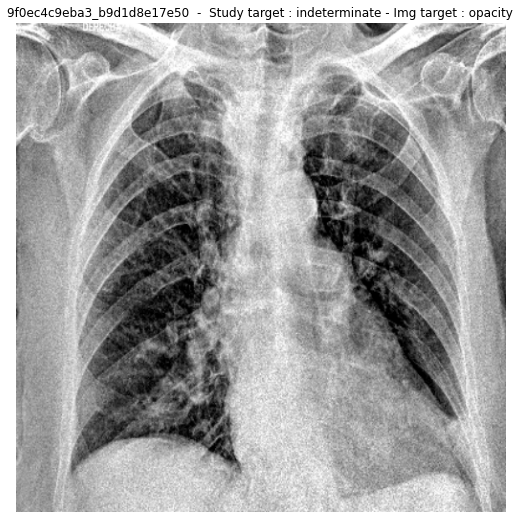

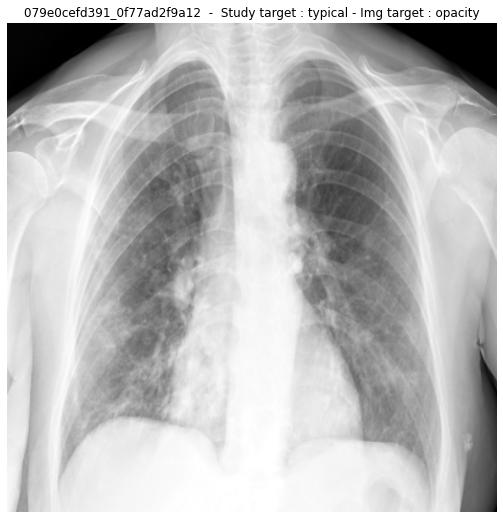

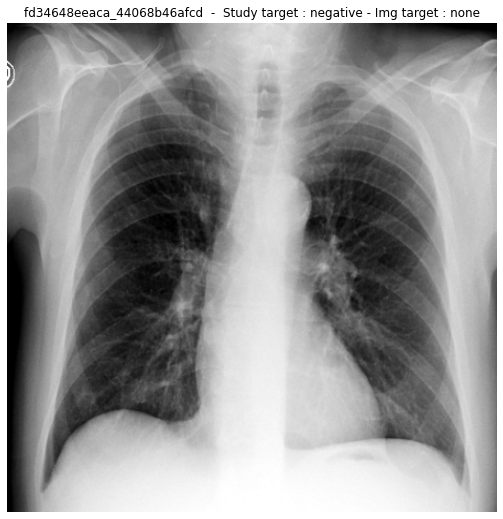

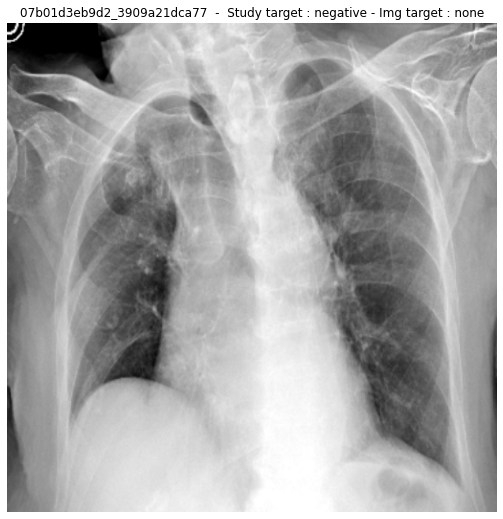

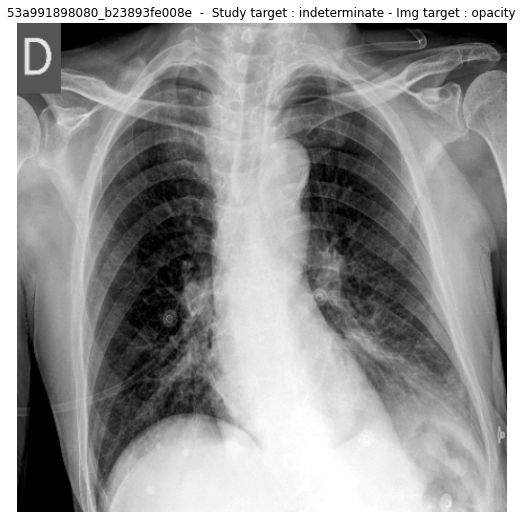

In [47]:
for i in np.random.choice(len(dataset), 10):
# for i in range(10):
#     img, mask, y, y_img, boxes = dataset[i]
    img, mask, y, y_img = dataset[i]
    boxes = []
    
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy().transpose(1, 2, 0)
        mask = mask.cpu().numpy()[:, :, None]

    if True:
        plt.figure(figsize  =(9, 9))
        plot_sample(img, boxes, bbox_format="yolo")
        plt.title(
            f'{df_["save_name"][i][:-4]}  -  Study target : {CLASSES[int(y)]} - '
            f'Img target : {CLASSES_IMG[int(y_img)]}'
        )
        plt.show()
#         break

## Model

In [20]:
# model = get_encoder('tf_efficientnet_b4_ns')

In [21]:
model = get_model('tf_efficientnetv2_s_in21ft1k', num_classes=4)

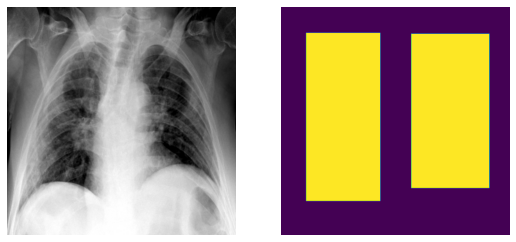

In [22]:
transforms = get_transfos_cls(augment=False)
dataset = CovidClsDataset(df, DATA_PATH + f"train_{SIZE}/", transforms=transforms)

x, m, y, y_img = dataset[0]

plt.figure(figsize=(9, 9))
plt.subplot(1, 2, 1)
plt.imshow(x.cpu().numpy().transpose(1, 2, 0))
plt.axis(False)
plt.subplot(1, 2, 2)
plt.imshow(m.cpu().numpy()[:, :, None])
plt.axis(False)

x = x.unsqueeze(0).float()
m = m.unsqueeze(0).float()
y = y.unsqueeze(0)
y_img = y_img.unsqueeze(0)

In [23]:
model.encoder.nb_fts

[48, 64, 160, 256]

In [24]:
pred = model(x)

In [25]:
for p in pred:
    try:
        print(p.size())
    except:
        for p_ in p:
            print(' ', p_.size())

torch.Size([1, 4])
torch.Size([1, 1])
  torch.Size([1, 1, 32, 32])
  torch.Size([1, 1, 16, 16])


### Training

In [26]:
BATCH_SIZES = {
    "resnext50_32x4d": 16,
    'tf_efficientnetv2_s_in21ft1k': 8, # 16
    'tf_efficientnetv2_m_in21ft1k': 12, #6
    'tf_efficientnetv2_l_in21ft1k': 6,
    'tf_efficientnet_b2_ns': 12,
    'tf_efficientnet_b3_ns': 16, 
    'tf_efficientnet_b4_ns': 12,
    'tf_efficientnet_b5_ns': 8,
}

In [27]:
class Config:
    """
    Parameters used for training
    """
    # General
    seed = 42
    verbose = 1

    size = SIZE
    bbox_format = "yolo"
    root_dir = DATA_PATH + f"train_{SIZE}/"
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_weights = True

    # k-fold
    k = 5
    folds_col = "kfold"
    selected_folds = [0, 1, 2, 3, 4]

    # Model
    selected_model = 'tf_efficientnetv2_m_in21ft1k'
    use_unet = True
    num_classes = len(CLASSES)

    # Training
    loss_config = {  
        "w_bce": 0.75,
        "w_seg_loss": 0.75 if "v2_m" in selected_model else 0.95,
        "seg_loss_multiplier": 2 if "v2_m" in selected_model else 4,
        "w_study": 2,
        "w_img": 1,
    }
    use_fp16 = True if "v2_m" in selected_model else False
    samples_per_patient = 1
    optimizer = ["Adam", "RAdam_lookahead", "RAdam"]
    batch_size = BATCH_SIZES[selected_model]
    epochs = [10] #, 5, 5]

    lr = [1e-3, 1e-4, 1e-5]
    warmup_prop = [0.05, 0.25, 0.5]
    val_bs = batch_size * 2

    first_epoch_eval = 0

    mix = "cutmix"
    mix_proba = 0.5
    mix_alpha = 0.4

    name = "model"

In [28]:
DEBUG = False
log_folder = None

In [ ]:
if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH)
    print(f'Logging results to {log_folder}')
    save_config(Config, log_folder + 'config')
    df.to_csv(log_folder + 'data.csv', index=False)
    create_logger(directory=log_folder, name="logs.txt")

pred_oof_study, pred_oof_img = k_fold(
    Config,
    df,
    df_extra=None,
    log_folder=log_folder
)

Logging results to ../logs/2021-08-04/6/

-------------   Fold 1 / 5  -------------

    -> 5064 training images
    -> 1269 validation images
    -> 60008754 trainable parameters

 - Training 1 / 1 : 	epochs: 10	lr: 1.0e-03	warmup_prop: 0.05	optimizer: Adam
Using 403 out of 422 batches by limiting to 1 samples per study.

Epoch 01/10 	 lr=9.5e-04	 t=181s 	loss=1.333	val_loss=1.128	study_map=0.332	img_auc=0.892
Epoch 02/10 	 lr=8.4e-04	 t=183s 	loss=1.166	val_loss=1.063	study_map=0.350	img_auc=0.894
Epoch 03/10 	 lr=7.4e-04	 t=184s 	loss=1.138	val_loss=1.113	study_map=0.344	img_auc=0.901
Epoch 04/10 	 lr=6.3e-04	 t=183s 	loss=1.119	val_loss=1.036	study_map=0.352	img_auc=0.899
Epoch 05/10 	 lr=5.3e-04	 t=183s 	loss=1.098	val_loss=1.043	study_map=0.363	img_auc=0.886
Epoch 06/10 	 lr=4.2e-04	 t=183s 	loss=1.078	val_loss=1.042	study_map=0.366	img_auc=0.895
Epoch 07/10 	 lr=3.2e-04	 t=183s 	loss=1.059	val_loss=1.043	study_map=0.361	img_auc=0.897
Epoch 08/10 	 lr=2.1e-04	 t=183s 	loss=1.043	